In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [ ]:
# Download data from Google Storage (already preformatted)

# !curl -k -o 101_food_classes_10_percent.zip https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

# unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 1550M    0 32884    0     0  36768      0 12:16:47 --:--:-- 12:16:47 36865
  0 1550M    0  502k    0     0   270k      0  1:37:38  0:00:01  1:37:37  271k
  0 1550M    0 10.9M    0     0  3790k      0  0:06:58  0:00:02  0:06:56 3793k
  1 1550M    1 24.9M    0     0  6230k      0  0:04:14  0:00:04  0:04:10 6234k
  2 1550M    2 32.6M    0     0  6680k      0  0:03:57  0:00:05  0:03:52 6682k
  2 1550M    2 45.2M    0     0  7826k      0  0:03:22  0:00:05  0:03:17 9211k
  3 1550M    3 57.1M    0     0  8345k      0  0:03:10  0:00:07  0:03:03 10.9M
  4 1550M    4 72.2M    0     0  9403k      0  0:02:48  0:00:07  0:02:41 12.4M
  5 1550M    5 87.3M    0     0   9.7M      0  0:02:38  0:00:08  0:02:30 12.8M
  6 1550M    6 97.8M    0     0   9.9M      0  0:02

In [4]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bread_pudding'.
There are 0 directories and 250 images in '10

In [18]:
img_size = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    label_mode='categorical',
    batch_size=32,
)

test_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    batch_size=32,
    image_size=img_size,
    shuffle = False
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [8]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

In [20]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [21]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 2s 0us/step


In [22]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [23]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data_all_10_percent,
                                           validation_steps=int(0.15 * len(test_data_all_10_percent)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5


237/237 [==============================] - 66s 253ms/step - loss: 3.3715 - accuracy: 0.2696 - val_loss: 2.5729 - val_accuracy: 0.4163
Epoch 2/5
237/237 [==============================] - 64s 270ms/step - loss: 2.2044 - accuracy: 0.4981 - val_loss: 2.0999 - val_accuracy: 0.4860
Epoch 3/5
237/237 [==============================] - 66s 279ms/step - loss: 1.8269 - accuracy: 0.5633 - val_loss: 1.9560 - val_accuracy: 0.5087
Epoch 4/5
237/237 [==============================] - 62s 262ms/step - loss: 1.6067 - accuracy: 0.6051 - val_loss: 1.8600 - val_accuracy: 0.5217
Epoch 5/5
237/237 [==============================] - 69s 290ms/step - loss: 1.4432 - accuracy: 0.6412 - val_loss: 1.8012 - val_accuracy: 0.5305


In [24]:
# Evaluate model 
results_feature_extraction_model = model.evaluate(test_data_all_10_percent)
results_feature_extraction_model

790/790 [==============================] - 53s 67ms/step - loss: 1.5882 - accuracy: 0.5843


[1.5882214307785034, 0.5843168497085571]

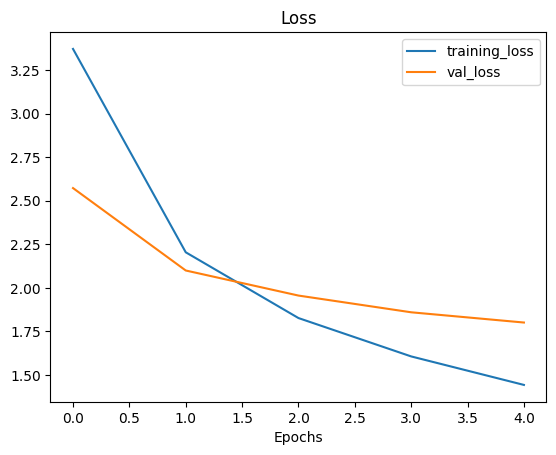

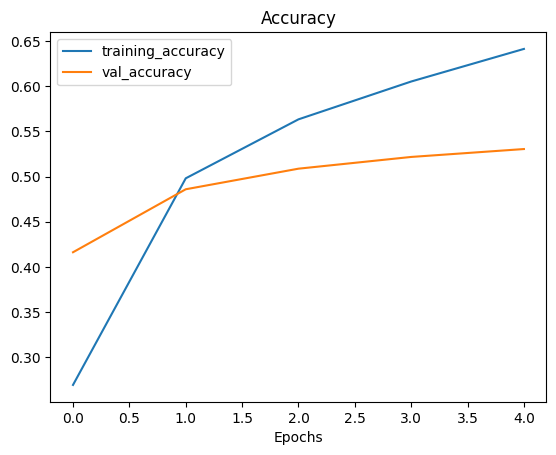

In [25]:
plot_loss_curves(history_all_classes_10_percent)

In [26]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model_V2 = tf.keras.Model(inputs, outputs)

In [27]:
model_V2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                           

In [30]:
# Compile
model_V2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent_model_V2 = model_V2.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data_all_10_percent,
                                           validation_steps=int(0.15 * len(test_data_all_10_percent)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5


237/237 [==============================] - 74s 277ms/step - loss: 1.6933 - accuracy: 0.5741 - val_loss: 1.8732 - val_accuracy: 0.5196
Epoch 2/5
237/237 [==============================] - 66s 277ms/step - loss: 1.5611 - accuracy: 0.6116 - val_loss: 1.8541 - val_accuracy: 0.5238
Epoch 3/5
 13/237 [>.............................] - ETA: 56s - loss: 1.4701 - accuracy: 0.6418

KeyboardInterrupt: 

In [31]:
# Evaluate model 
results_feature_extraction_model_model_V2 = model_V2.evaluate(test_data_all_10_percent)
results_feature_extraction_model_model_V2

790/790 [==============================] - 55s 69ms/step - loss: 1.5859 - accuracy: 0.5800


[1.5859391689300537, 0.5799999833106995]